# Homework-  26.11.2018:
## State of the Art Neural Network Architectures

The purpose of this homework is to implement and evaluate the sota architectures presented in the lecture.
However, you are encouraged to try your own layer module ideas.
Feel free to consult the [Keras source code](https://github.com/keras-team/keras-applications):




1. Based on the CNN modules presented in the lecture e.g. VGG16, Inception, ResNet, Xception, DenseNet, come up with your own CNN module and write a small text discussing your idea and motivations behind the module.

2. Evaluate all your module using the Keras CIFAR10 dataset splits (The model with best test accuracy will present their solution to the class).

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
!ls "content/drive/My Drive"

ls: cannot access 'content/drive/My Drive': No such file or directory


3. Evaluate your module using the FERPlus dataset (The model with the best test accuracy will present their solution to the class).

    3.1 Download the [FER2013 dataset](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) (images_path).
    
    3.2 Download the [FERPlus labels](https://github.com/Microsoft/FERPlus/blob/master/fer2013new.csv) (labels_path).
    
    3.3 Use the following code snippet to load the dataset giving the appropiate paths to the csv files downloaded in 3.1 and 3.2:

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
plt.imshow(x_train[100])
plt.show()



In [0]:
class FERPlus(object):
    """Class for loading FER2013 [1] emotion classification dataset with
    the FERPlus labels [2]:
    [1] kaggle.com/c/challenges-in-representation-learning-facial-\
            expression-recognition-challenge
    [2] github.com/Microsoft/FERPlu://github.com/Microsoft/FERPlus"""

    def __init__(self, images_path, labels_path, split='train', image_size=(48, 48),
                 dataset_name='FERPlus'):

        self.split = split
        self.image_size = image_size
        self.dataset_name = dataset_name
        self.images_path = images_path
        self.labels_path = labels_path
        self.class_names = ['neutral', 'happiness', 'surprise', 'sadness',
                            'anger', 'disgust', 'fear', 'contempt']
        self.num_classes = len(self.class_names)
        self.arg_to_name = dict(zip(range(self.num_classes), self.class_names))
        self.name_to_arg = dict(zip(self.class_names, range(self.num_classes)))
        self._split_to_filter = {
            'train': 'Training', 'val': 'PublicTest', 'test': 'PrivateTest'}

    def load_data(self):
        filter_name = self._split_to_filter[self.split]
        pixel_sequences = pd.read_csv(self.images_path)
        pixel_sequences = pixel_sequences[pixel_sequences.Usage == filter_name]
        pixel_sequences = pixel_sequences['pixels'].tolist()
        faces = []
        for pixel_sequence in pixel_sequences:
            face = [float(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(48, 48)
            faces.append(cv2.resize(face, self.image_size))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        emotions = pd.read_csv(self.labels_path)
        emotions = emotions[emotions.Usage == filter_name]
        emotions = emotions.iloc[:, 2:10].values
        N = np.sum(emotions, axis=1)
        mask = N != 0
        N, faces, emotions = N[mask], faces[mask], emotions[mask]
        emotions = emotions / np.expand_dims(N, 1)
        return faces, emotions

In [0]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Convolution2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
import keras.utils
import cv2
from keras.models import Model
# from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
# if K.backend()=='tensorflow':
#     K.set_image_dim_ordering("th")
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

import seaborn as sn
import pandas  as pd

from sklearn.metrics import classification_report, confusion_matrix

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True

n = 3
depth = n * 9 + 2

FER_Data = FERPlus('drive/My Drive/Colab Notebooks/FERPlus_data/fer2013/fer2013.csv', \
                   'drive/My Drive/Colab Notebooks/FERPlus_data/FERPlus/fer2013new.csv',split='train')
x_train, y_train = FER_Data.load_data()
FER_Data = FERPlus('drive/My Drive/Colab Notebooks/FERPlus_data/fer2013/fer2013.csv', \
                   'drive/My Drive/Colab Notebooks/FERPlus_data/FERPlus/fer2013new.csv',split='test')
x_test, y_test = FER_Data.load_data()
print(x_train.shape)
print(x_test.shape)
print(FER_Data.num_classes)
num_classes = FER_Data.num_classes

# # Load the CIFAR10 data.
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# num_classes = 10
#------------ Preprocessing ------------
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255 

# Substract mean
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

# ----- Callbacks functions -----
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# # Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_acc',
#                              verbose=1,
#                              save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Network Structure: 
#    1- Conv 32 feature maps with 3x3 with relu
#    2- Conv 32 feature maps with 3x3 relu
#    3- MaxPooling 2x2
#    4- Dropout 25%
#    5- Conv 64 feature maps with 3x3 relu
#    6- Conv 64 feature maps with 3x3 relu
#    7- MaxPooling layer with 2x2 
#    8- Dropout 25%
#    9- Flatten layer
#   10- fully connected layer with 512 units and relu
#   11- Dropout 25%
#   12- Fully connected layer with 10 units and softmax
# https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/

# Create the model
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

  
num_filters_in = 16
num_res_blocks = int((depth - 2) / 9)

inputs = Input(shape=input_shape)

x = resnet_layer(inputs=inputs,
                 num_filters=num_filters_in,
                 conv_first=True)

for stage in range(3):
    for res_block in range(num_res_blocks):
        activation = 'relu'
        batch_normalization = True
        strides = 1
        if stage == 0:
            num_filters_out = num_filters_in * 4
            if res_block == 0:  # first layer and first stage
                activation = None
                batch_normalization = False
        else:
            num_filters_out = num_filters_in * 2
            if res_block == 0:  # first layer but not first stage
                strides = 2    # downsample

        # bottleneck residual unit
        y = resnet_layer(inputs=x,
                         num_filters=num_filters_in,
                         kernel_size=1,
                         strides=strides,
                         activation=activation,
                         batch_normalization=batch_normalization,
                         conv_first=False)
        y = Dropout(0.2)(y)
        
        y = resnet_layer(inputs=y,
                         num_filters=num_filters_in,
                         conv_first=False)
        y = Dropout(0.2)(y)
        
        y = resnet_layer(inputs=y,
                         num_filters=num_filters_out,
                         kernel_size=1,
                         conv_first=False)
        y = Dropout(0.2)(y)
        
        if res_block == 0:
            # linear projection residual shortcut connection to match
            # changed dims
            x = resnet_layer(inputs=x,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             strides=strides,
                             activation=None,
                             batch_normalization=False)
            
        x = keras.layers.add([x, y])

    num_filters_in = num_filters_out

# Add classifier on top
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = AveragePooling2D(pool_size=8)(x)
x = MaxPooling2D(pool_size=8)(x)
# y = Flatten()(x)
y = Dense(1024, activation='relu', kernel_constraint=maxnorm(3))(y)
y = Dropout(0.2)(y)
y = Dense(512, activation='relu', kernel_constraint=maxnorm(3))(y)
y = Dropout(0.2)(y)
y = Convolution2D(filters=256, kernel_size=(3, 3), padding='same') (y)
y = AveragePooling2D(pool_size=(2, 2), padding='same')(y)
y = Dropout(0.5)(y)
y = BatchNormalization() (y)
y = Convolution2D(filters=num_classes, 
                  kernel_size=(3, 3), 
                  padding='same')(y)
y = GlobalAveragePooling2D()(y)
outputs = Activation('softmax', name='predictions')(y)

# outputs = Dense(num_classes,
#                 activation ='softmax',
#                 kernel_initializer='he_normal')(y)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,steps_per_epoch=1000,
                        callbacks=callbacks)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


(28559, 48, 48, 1)
(3573, 48, 48, 1)
8
x_train shape: (28559, 48, 48, 1)
28559 train samples
3573 test samples
y_train shape: (28559, 8)
Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 48, 48, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 48, 48, 16)   64          conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 48, 48, 16

In [0]:
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import AveragePooling2D, Input, Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.utils import np_utils
# from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
# if K.backend()=='tensorflow':
#     K.set_image_dim_ordering("th")
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10

import seaborn as sn
import pandas  as pd

from sklearn.metrics import classification_report, confusion_matrix

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True
num_classes = 10
n = 3
depth = n * 9 + 2

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#------------ Preprocessing ------------
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255 

# Substract mean
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# ----- Callbacks functions -----
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# # Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_acc',
#                              verbose=1,
#                              save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Network Structure: 
#    1- Conv 32 feature maps with 3x3 with relu
#    2- Conv 32 feature maps with 3x3 relu
#    3- MaxPooling 2x2
#    4- Dropout 25%
#    5- Conv 64 feature maps with 3x3 relu
#    6- Conv 64 feature maps with 3x3 relu
#    7- MaxPooling layer with 2x2 
#    8- Dropout 25%
#    9- Flatten layer
#   10- fully connected layer with 512 units and relu
#   11- Dropout 25%
#   12- Fully connected layer with 10 units and softmax
# https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/

# Create the model
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

  
num_filters_in = 16
num_res_blocks = int((depth - 2) / 9)

inputs = Input(shape=input_shape)

x = resnet_layer(inputs=inputs,
                 num_filters=num_filters_in,
                 conv_first=True)

for stage in range(3):
    for res_block in range(num_res_blocks):
        activation = 'relu'
        batch_normalization = True
        strides = 1
        if stage == 0:
            num_filters_out = num_filters_in * 4
            if res_block == 0:  # first layer and first stage
                activation = None
                batch_normalization = False
        else:
            num_filters_out = num_filters_in * 2
            if res_block == 0:  # first layer but not first stage
                strides = 2    # downsample

        # bottleneck residual unit
        y = resnet_layer(inputs=x,
                         num_filters=num_filters_in,
                         kernel_size=1,
                         strides=strides,
                         activation=activation,
                         batch_normalization=batch_normalization,
                         conv_first=False)
        y = Dropout(0.2)(y)
        
        y = resnet_layer(inputs=y,
                         num_filters=num_filters_in,
                         conv_first=False)
        y = Dropout(0.2)(y)
        
        y = resnet_layer(inputs=y,
                         num_filters=num_filters_out,
                         kernel_size=1,
                         conv_first=False)
        y = Dropout(0.2)(y)
        
        if res_block == 0:
            # linear projection residual shortcut connection to match
            # changed dims
            x = resnet_layer(inputs=x,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             strides=strides,
                             activation=None,
                             batch_normalization=False)
            
        x = keras.layers.add([x, y])

    num_filters_in = num_filters_out

# Add classifier on top
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = AveragePooling2D(pool_size=8)(x)
x = MaxPooling2D(pool_size=8)(x)
y = Flatten()(x)
y = Dense(1024, activation='relu', kernel_constraint=maxnorm(3))(y)
y = Dropout(0.2)(y)
y = Dense(512, activation='relu', kernel_constraint=maxnorm(3))(y)
y = Dropout(0.2)(y)

outputs = Dense(num_classes,
                activation ='softmax',
                kernel_initializer='he_normal')(y)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,steps_per_epoch=1000,
                        callbacks=callbacks)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 3, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 16, 32, 32)   448         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_151 (BatchN (None, 16, 32, 32)   128         conv2d_177[0][0]                 
__________________________________________________________________________________________________
activation_151 (Activation)     (None, 16, 32, 32)   0           batch_normalization_15

KeyboardInterrupt: ignored

In [0]:
"""Trains a ResNet on the CIFAR10 dataset.
ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf
ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,steps_per_epoch=1000,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 32, 32, 16)   64          conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 32, 32, 16)   0           batch_normalization_29

KeyboardInterrupt: ignored

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


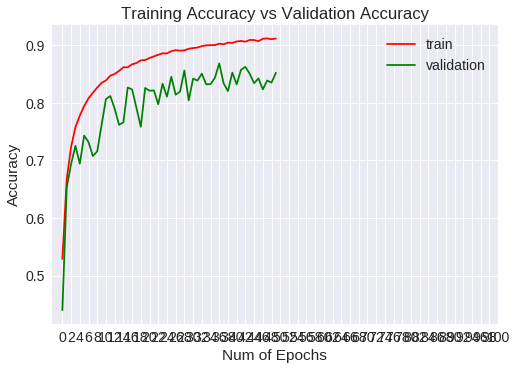

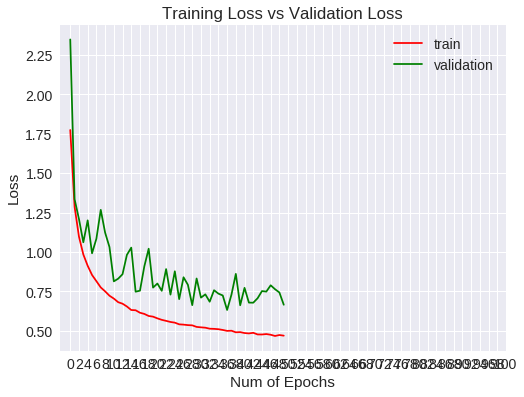

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[877   5  46   0  10   0  12   3  24  23]
 [  4 894   1   0   1   0   5   1   8  86]
 [ 20   2 833   4  42  18  65  12   2   2]
 [  9   5  51 508  92 151 136  19   5  24]
 [  7   1  22   1 908  15  33  12   0   1]
 [  6   1  21  22  40 840  48  16   0   6]
 [  4   0  18   1   8   0 962   1   2   4]
 [  3   0  12   4  46  32  17 879   0   7]
 [ 66   7   8   0   2   1   5   3 875  33]
 [ 10  21   2   1   1   0   6   4   7 948]]


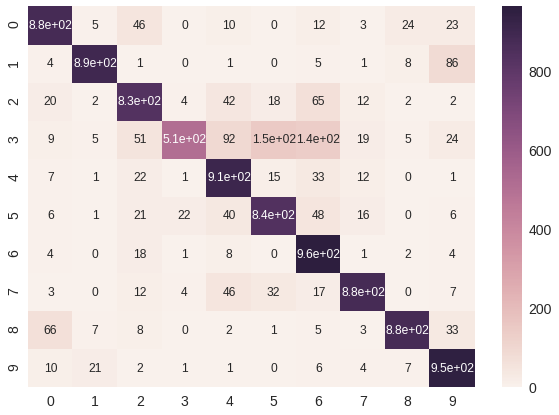

In [0]:

# sequential_model_to_ascii_printout(model2)
import matplotlib.pyplot as plt
import seaborn as sn
import pandas  as pd
from sklearn.metrics import classification_report, confusion_matrix

print(model.history.history.keys())
plt.figure(0)
plt.plot(model.history.history['acc'],'r')
plt.plot(model.history.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(model.history.history['loss'],'r')
plt.plot(model.history.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()


Y_pred = model.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

## Models
* InceptionV3
* DenseNet
* NasNet

## Hyperparameters
* Dense layer size
* Dropout probability
* Number of fixed layers
* Learning rate 
* decay schedule
* batch size
* epochs